# 목차

- Step 1. 데이터 수집하기
- Step 2. 데이터 전처리하기 (추상적 요약)
- Step 3. 어텐션 메커니즘 사용하기 (추삭적 요약)
- Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
- Step 5. Summa을 이용해서 추출적 요약해보기
- 회고
    - 이번 프로젝트에서 어려웠던 점
    - 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 루브릭 평가 지표를 맞추기 위해 시도한 것들
    - 만약에 루브릭 평가 관련 지표를 달성하지 못했을 때, 이유에 관한 추정
    - 자기 다짐

# 8-13. 프로젝트: 뉴스기사 요약해보기

새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.



## 필요한 라이브러리 import

In [27]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(`news_summary_more.csv`)를 사용하세요.

- [sunnysai12345/News_Summary]()

아래의 코드로 데이터를 다운로드할 수 있어요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
10809,What is Muhurat trading on Diwali?,A special Muhurat trading session will be held...
84120,Shilpa Shetty performs Bakasana on Internation...,Actress Shilpa Shetty has shared a video of he...
77684,"N Korea uses hackers to make money, not espion...",North Korea is behind an increasingly arranged...
66269,Will take 'tough call' on Tata Teleservices: C...,Tata Sons Chairman N Chandrasekaran has said t...
64857,10 killed as truck overturns in Maharashtra's ...,At least 10 people were killed and five injure...
31631,Player in Ireland's 1st Test squad has already...,"Pacer Boyd Rankin, who is a part of Ireland's ..."
30816,"Bravo performs 'Champion' as Dhoni, Raina's da...",Chennai Super Kings have shared a video in whi...
77821,"Pak interim PM nominee faces Ã¢ÂÂ¹13,000 cror...",Pakistan's interim Prime Minister nominee Shah...
65922,Many scripts for elderly actors but not actres...,Veteran actress Sharmila Tagore has said that ...
74560,No inconsistency in number of taxpayers added:...,Central Board of Direct Taxes has clarified th...


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

### 1-1) 데이터 확인하기

- 데이터의 `중복값`과 `null`값이 있는지 확인한다.
- 앞선 예제와 달리, 여기서는 `headlines`가 `Summary`와 대응된다.

In [4]:
# 중복값 확인
print('원래 데이터의 수 :', len(data))
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

원래 데이터의 수 : 98401
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- 중복되지 않은 `text`의 수가 `headlines`의 수 보다 더 많은 것을 알 수 있다.
- `headlines` 요약에 사용되지 않은 `text`가 있다는 뜻으로 해석할 수 있다.

In [5]:
# null값이 있는지 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


- `text`와 `headlines`모두 null값이 없는 데이터 이다.

## Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 2-1) null과 중복값 삭제

- lms와는 조금 다른 순서로, `dropna`를 먼저 실행시켜서 null값을 삭제하고 `drop_duplicates()`를 이용하여 중복값을 삭제하는 함수 `drop`을 생성
- 하지만, 위에서 데이터를 확인해 본 결과 ***null값이 없는 데이터***였으므로, <u>그냥 상징적으로 `dropna`를 넣어두는 것</u>으로 함수를 만들었다.

In [6]:
def drop(data):

    data.dropna(axis=0, inplace=True)
    data.drop_duplicates(subset = ['text'], inplace=True)

    return data

# 리턴 값을 data에 할당
data = drop(data)

In [7]:
print('중복값을 제거한 데이터의 샘플 수 :', (len(data)))

중복값을 제거한 데이터의 샘플 수 : 98360


- `text`열에서의 중복값을 제거하였으므로, `98360`개의 데이터만 남았다.

### 2-2) 텍스트 정규화와 불용어 제거

- `it'll`과 `it will` / `mustn't`과 `must not` 같이 의미인데도 다른 표현으로 쓰여 마치 다른 단어들처럼 간주되는 경우, 기계학습 전에 미리 같은 표현으로 통일 시켜줘서 학습의 연산량을 줄이는 방법론을 ***텍스트 정규화 (text normalization)***이라고 한다.
- lms에서 만든 <u>텍스트 정규화 사전(dictionary)</u>은 아래와 같이 구성되어 있다. (아래 링크를 참고하여 만들었다고 함)
- - [정규화 사전 출처](https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python)

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


 - **NLTK에서 제공하는 불용어 리스트**를 참조해서 데이터에서 불용어를 제거

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

- NLTK에서 미리 정의하여 제공하고 있는 불용어는 총 `179개`이다.

- 모든 영어 문자는 **소문자**로 
- 섞여있는 html 태그를 제거
- **정규 표현식**을 통해 각종 특수문자를 제거
- 함수의 하단을 보면 **NLTK**를 이용해서 불용어 제거
- 'text` 전처리 시에만 호출하고 상대적으로 문장 길이가 짧은 `headlines`를 전처리를 할 때는 호출하지 않음
- 추상적인 문장 요약 결과문이 자연스러운 문장이 되려면 이 불용어들이 `headlines`에는 남아 있는 게 더 좋음 (`text`에서만 불용어 삭제!)
- 이 처리를 위해서 함수의 인자로 `remove_stopwords`를 추가하고 `if문`을 추가

In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


- 전처리 전, 후의 결과를 확인하기 위해서 임의의 `text`와 `headlines`를 만들어 함수를 호출해 본다.



In [11]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


- 모든 알파벳이 소문자로 변환
- html 태그 제거됨
- 특수문자 제거됨

- 전체 `data`에 전처리 수행
- `text`에는 불용어 제거
- `headlines`에서는 불용어 제거하지 않음
- 따로 호출해서 진행해야한다.


In [12]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

- `headlines`에 대해서 전처리 함수를 호출해 줄 때는, 불용어 제거를 수행하지 않는다는 의미에서 두 번째 인자로 ***False***를 넣어준다.

In [14]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


- ***텍스트 정제과정을 거친 후***에는 <u>다시 한 번 빈(empty) 샘플이 생겼는지 확인</u>
- 정제 전에는 데이터가 존재했지만, 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있기 때문
- 시각적으로 알아보기 쉽게 데이터프레임에 재저장
- `빈(empty)값`을 가진 샘플은 `Null`으로 표현된다.

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


- `data.isnull().sum()`을 사용해서 `Null`값이 생겼는지 확인

In [16]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

- `Null` 값이 생기지 않았다.

### 2-3) 훈련데이터와 테스트데이터 나누기

- 학습을 진행하기 위해서는 학습에 사용할 <u>데이터의 크기</u>를 결정하고, <u>문장의 시작과 끝을 표시</u>해 줘야 한다.

**샘플의 최대 길이 정하기**

- 훈련에 사용할 샘플의 **최대 길이**를 정해준다.
- `text`와 `headlines`의 **최소**, **최대**, **평균 길이**를 구하고 또한 <u>길이 분포를 시각화</u>

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


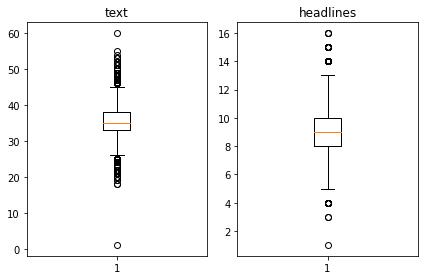

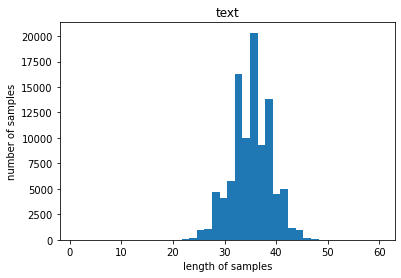

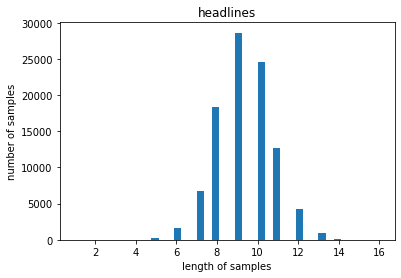

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- `text` : 최소길이 `1`, 최대길이 `60`, 평균길이 `약 35`인데, 시각화된 그래프를 보면 유의미한 길이는 ***약 20~50*** 정도일 것으로 추정된다.
- `headlines` : 최소길이 `1`, 최대길이 `16`, 평균길이 `약 9.2`인데, 시각화된 그래프를 보면 유의미한 길이는 ***약 5~14*** 정도일 것으로 추정된다.
- `text`, `headlines` 모두 훈련 데이터로 쓸 `max_len`을 임의로 정해준다.

In [18]:
text_max_len = 50
headlines_max_len = 14
print('=3')

=3


- 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있을지 통계로 확인
- 훈련 데이터와 샘플의 길이를 입력하면, <u>데이터의 몇 %가 해당하는지 계산하는 함수</u>를 만들어서 확인 해 본다.

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 14 이하인 샘플의 비율: 0.9997763318422123


- 각각 `50`과 `14`로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 된다.
- 각각 <u>약 1% 정도</u>가 내용이 망가질 우려가 있다. 많은 양의 샘플은 아니지만, 완성되지 않은 문장으로 기계 학습을 시키면 정확한 학습이 되지 않을 수도 있다.
- 해당 길이 이상이면 문장을 자르는 것이 아니라, 그 문장을 제외하는 방법을 사용하도록 하자

In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98324


### 2-4) 시작 토큰과 종료 토큰 추가하기

- ***디코더***는 **시작 토큰**을 입력받아 <u>문장을 생성하기 시작</u>하고, <u>**종료 토큰**을 예측한 순간에 문장 생성을 멈추는 것</u>

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-21-4.png)

- ***seq2seq*** 훈련을 위해서는 디코더의 입력과 레이블에 시작 토큰과 종료 토큰을 추가 해야 한다. 
- 시작 토큰 `sostoken`, 종료 토큰 `eostoken`을 앞, 뒤로 추가
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 `decoder_input`, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 `decoder_target`으로 정한다.
- 두 개의 문장 모두 `headlines` 열로 만든다.

In [23]:
# 헤드라인 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


- 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [24]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


- **훈련 데이터와 테스트 데이터를 분리**

- 훈련 데이터와 테스트 데이터를 분리하는 방법은 분리 패키지를 사용하는 방법, 또는 직접 코딩을 통해서 분리하는 방법 등 여러 가지 방법이 있다.
- 직접하지 않고 분리해 본다.

- `encoder_input`과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어준다.

In [25]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[61085 90349  8989 ... 31831 92808 22531]


- 이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 된다.

In [26]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


- 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19664


 - 테스트 데이터의 개수를 이용해 전체 데이터를 양분한다.
 - `:`표시의 위치에 주의

In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


### 2-5) 정수 인코딩

**단어 집합(vocabulary) 만들기 및 정수 인코딩**

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 줘야 한다.
- 각 단어에 고유한 정수를 맵핑하는 작업이 필요
- 이 과정을 <U>**단어 집합(vocabulary)**</U> 을 만든다고 표현한다.
- `Keras`의 ***토크나이저***를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있다.

- 훈련 데이터에 대해서 단어 집합을 만들어본다.
- 우선, 원문에 해당되는 `encoder_input_train`에 대해서 단어 집합을 만든다.


In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


- 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- 현재 생성된 단어 집합은 `src_tokenizer.word_index`에 저장


- 모든 단어를 사용하는 것이 아니라, <u>빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행</u>하려 한다.
- 등장 빈도수가 `7회 미만`인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인
- `src_tokenizer.word_counts.items()`에는 단어와 각 단어의 등장 빈도수가 저장되어 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69563
등장 빈도가 6번 이하인 희귀 단어의 수: 47358
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22205
단어 집합에서 희귀 단어의 비율: 68.07929502752901
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4879006471515153


- `encoder_input_train`에는 `7만여 개`의 단어가 있다.

- 등장 빈도가 threshold 값인 7회 미만, 즉 `6회 이하`인 단어들은 단어 집합에서 무려 `약 68% 이상`을 차지한다.
-  하지만 실제로 훈련 데이터에서 <u>등장 빈도로 차지하는 비중은</u> 상대적으로 적은 수치인 `약 3.49%`밖에 되지 않는다.

- 등장 빈도가 6회 이하인 단어들은 <u>정수 인코딩 과정에서 빼고,</u> 훈련 데이터에서 제거한다.
- 단어 집합의 크기를 `22,200`으로 제한
- 토크나이저를 정의할 때 <u>num_words</u>의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [32]:
src_vocab = 22200
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,200으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


- `texts_to_sequences()`는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다.
- 현재 단어 집합의 크기를 `22,200`으로 제한했으니까 이제 `22,200`이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[214, 509, 270, 116, 2835, 366, 3374, 454, 1592, 8382, 2191, 14278, 54, 30, 14278, 1646, 1656, 3375, 2191, 4611, 7471, 7066, 536, 191, 1592, 136, 268, 878, 4166, 2370, 32, 1147, 14278, 34, 387, 492, 2533, 343], [38, 87, 2795, 2599, 69, 71, 2159, 33, 6254, 2581, 2923, 2025, 1014, 761, 2990, 107, 2599, 34, 4011, 225, 812, 2025, 1035, 6254, 3761, 733, 1566, 681, 10272, 485, 17, 231, 225, 1460, 2025], [8258, 2192, 3145, 1368, 1090, 5196, 278, 181, 3007, 21, 7, 1713, 1047, 156, 585, 626, 10995, 4167, 3977, 331, 812, 3, 13, 15337, 83, 886, 87, 601, 1175, 215, 18, 293, 617, 397, 1176, 3601, 1709, 1090]]


- 텍스트 데이터가 아닌 정수가 나오고 있는지를 확인


- `headlines` 데이터에 대해서도 동일한 작업을 수행
- 토크나이저를 사용하여 `decoder_input_train`을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산한다.

In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


- 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.
- `tar_tokenizer.word_index`에 저장되어 있음

- `tar_tokenizer.word_counts.items()`에는 <u>단어</u>와 각 단어의 <u>등장 빈도수</u>가 저장되어 있는데, 이를 통해서 통계적인 정보를 얻어서, <u>**등장 빈도수가 6회 미만**</u>인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해 본다.

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30124
등장 빈도가 5번 이하인 희귀 단어의 수: 19721
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10403
단어 집합에서 희귀 단어의 비율: 65.46607356260789
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.679739982881259


- 등장 빈도가 **5회 이하**인 단어들은 단어 집합에서 `약 65%`를 차지하고 있다.
- 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 `약 4.68%`밖에 되지 않는다. 
- 아까 했던 것과 동일하게 이 단어들은 모두 제거한다. 
- 어림잡아 `10,400`을 단어 집합의 크기로 제한한다.

In [36]:
tar_vocab = 10400
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 143, 943, 1573, 9509, 3, 71, 300, 1976, 17, 36], [1, 2639, 92, 3114, 3495, 19, 796, 1614, 1221], [1, 1034, 3406, 1090, 6163, 214, 35, 919, 125, 8192, 745], [1, 6494, 165, 181, 675, 39, 8781, 12, 2138, 1171], [1, 4280, 9510, 3, 200, 3256, 4, 350, 398, 6836, 315]]
target
decoder  [[143, 943, 1573, 9509, 3, 71, 300, 1976, 17, 36, 2], [2639, 92, 3114, 3495, 19, 796, 1614, 1221, 2], [1034, 3406, 1090, 6163, 214, 35, 919, 125, 8192, 745, 2], [6494, 165, 181, 675, 39, 8781, 12, 2138, 1171, 2], [4280, 9510, 3, 200, 3256, 4, 350, 398, 6836, 315, 2]]


- 정상적으로 정수 인코딩 작업이 끝났다.
- `decoder_input_train`과 `decoder_target_train`에는 더 이상 숫자 `10,400`이 넘는 숫자들은 존재하지 않음.

 📌***다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것***📌

 <br>

- 전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 <u>빈(empty) 샘플이 되었을 가능성이 있다.</u>
- 이 현상은 길이가 상대적으로 길었던 원문(text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 `약 9`밖에 되지 않았던 헤드라인(headlines)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다.

<br>

- 헤드라인에서 길이가 `0`이 된 샘플들의 인덱스를 받아와본다.
- ***여기서 주의할 점***은 헤드라인인 `decoder_input`에는 `sostoken` 또는 `decoder_target`에는 `eostoken`이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않기 때문에 <u>길이가 `0`이 된 요약문의 실제 길이는 `1`로 나올 것이다.</u>
- 길이 0이 된 `decoder_input`에는 `sostoken`, `decoder_target`에는 `eostoken`만 남아 있음

<br>

- 훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 `1`인 경우의 인덱스를 각각 `drop_train`과 `drop_test`에 라는 변수에 저장해본다.
- 이 샘플들은 모두 삭제할 예정이다.



In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78660
훈련 레이블의 개수 : 78660
테스트 데이터의 개수 : 19664
테스트 레이블의 개수 : 19664


- 삭제할 데이터가 없다.

### 2-6) 

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

## Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.